In [108]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
from DelayControlSystem.delay_control import *

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.family"] = "Times New Roman"

In [109]:
class PIDController:
    def __init__(self, Kp=1.0, Ki=0.0, Kd=0.0, dt=0.01, N=100):
        self.Kp = np.array(Kp)
        self.Ki = np.array(Ki)
        self.Kd = np.array(Kd)
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0
        self.N = N  # Derivative filter coefficient
        self.derivative_filtered = 0.0

    def __call__(self):
        print("The PID controller Gains are")
        print(f"Kp: {self.Kp}, Ki: {self.Ki}, Kd: {self.Kd}")

    def compute(self, setpoint, measurement):
        error = setpoint - measurement
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt if self.dt > 0 else 0.0
        self.derivative_filtered = (
            (self.N * self.dt * derivative + self.derivative_filtered)
            / (self.N * self.dt + 1)
            if hasattr(self, "derivative_filtered")
            else derivative
        )
        output = (
            (self.Kp * error)
            + (self.Ki * self.integral)
            + (self.Kd * self.derivative_filtered)
        )
        self.prev_error = error
        return output

    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0
        self.derivative_filtered = 0.0

    def update_gains(self, Kp, Ki, Kd):
        self.Kp = np.array(Kp)
        self.Ki = np.array(Ki)
        self.Kd = np.array(Kd)

    def IMC_tune(self, lambda_c, K, tau, theta):
        K_c = tau / (K * (lambda_c + theta))
        tau_i = tau
        Kp = K_c
        Ki = K_c / tau_i
        Kd = 0.0
        self.update_gains(Kp, Ki, Kd)

In [110]:
K = 1
tau = 1
theta = 0.1

G = ctrl.TransferFunction([K], [tau, 1])  # Plant Transfer Function
delay_time = theta  # Delay time in seconds
print(G)

<TransferFunction>: sys[30]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    1
  -----
  s + 1


The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp: [5.], Ki: [5.], Kd: 0.0
The PID controller Gains are
Kp

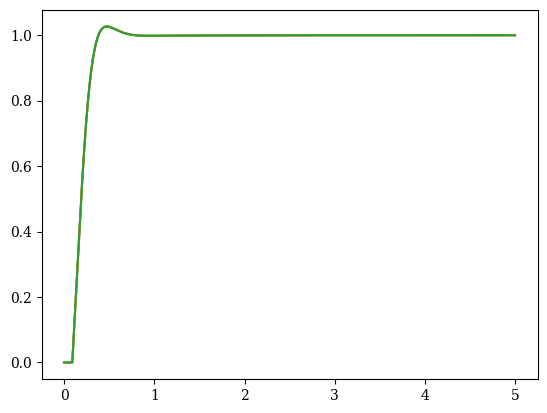

In [ ]:
dt = 0.01  # Time step for simulation
time = np.arange(0, 5, dt)  # Simulation time vector

Kp = 1.0
Ki = 1.0
Kd = 0.5

pid = PIDController(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt)
Plant = DelayControlSystem(G, delay_time, dt)
for lambda_c in [0.2, 0.1, 0.05]:
    Plant.reset()
    pid.reset()
    for i, _ in enumerate(time):

        setpoint = 1.0  # Desired setpoint
        measurement = Plant.y[-1] if Plant.y else 0.0
        error = setpoint - measurement
        lambda_c = np.clip(np.exp((error)), 0.01, 1)
        pid.IMC_tune(lambda_c=0.1 * lambda_c, K=K, tau=tau, theta=theta)
        pid()
        u = pid.compute(setpoint, measurement)
        Plant.step(u)

    plt.plot(Plant.t, Plant.y, label="Output with Delay")
plt.show()

In [112]:
import sympy as sp

s, tau, K, theta, lambda_, Kp, Ki, Kd, D = sp.symbols("s tau K theta lambda Kp Ki Kd D")
G_sp = K / ((tau * s + 1))
G_sn = D
display(G_sp * G_sn)
F = 1 / (lambda_ * s + 1)
display(F)

D*K/(s*tau + 1)

1/(lambda*s + 1)

In [113]:
C_IMC = F / G_sp
display(C_IMC)

(s*tau + 1)/(K*(lambda*s + 1))

In [114]:
C_PID = Kp + Ki / s + Kd * s
C = (C_IMC / (1 - F * G_sn)).simplify()
display(C)

(s*tau + 1)/(K*(-D + lambda*s + 1))

In [115]:
C = C.subs(D, (1 - theta * s))
display(C)
C = C.simplify()
display(C)
num, den = C.as_numer_denom()
num_coef = sp.Poly(sp.expand(num), s).all_coeffs()
den_coef = sp.Poly(sp.expand(den), s).all_coeffs()
display(num_coef)
display(den_coef)
Kp_expr = num_coef[0] / den_coef[0]
Ki_expr = num_coef[1] / den_coef[0]
print("PID Gains from IMC tuning:")
print(f"Kp: {Kp_expr}")
print(f"Ki: {Ki_expr}")

(s*tau + 1)/(K*(lambda*s + s*theta))

(s*tau + 1)/(K*s*(lambda + theta))

[tau, 1]

[K*lambda + K*theta, 0]

PID Gains from IMC tuning:
Kp: tau/(K*lambda + K*theta)
Ki: 1/(K*lambda + K*theta)
